In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [21]:
import kagglehub

# This will download the dataset and return the path to the extracted folder
path = kagglehub.dataset_download("retailrocket/ecommerce-dataset")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/ecommerce-dataset


In [55]:
import os

# Data loading
events_csv_path = os.path.join(path, "events.csv")
events = pd.read_csv(events_csv_path)
events.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


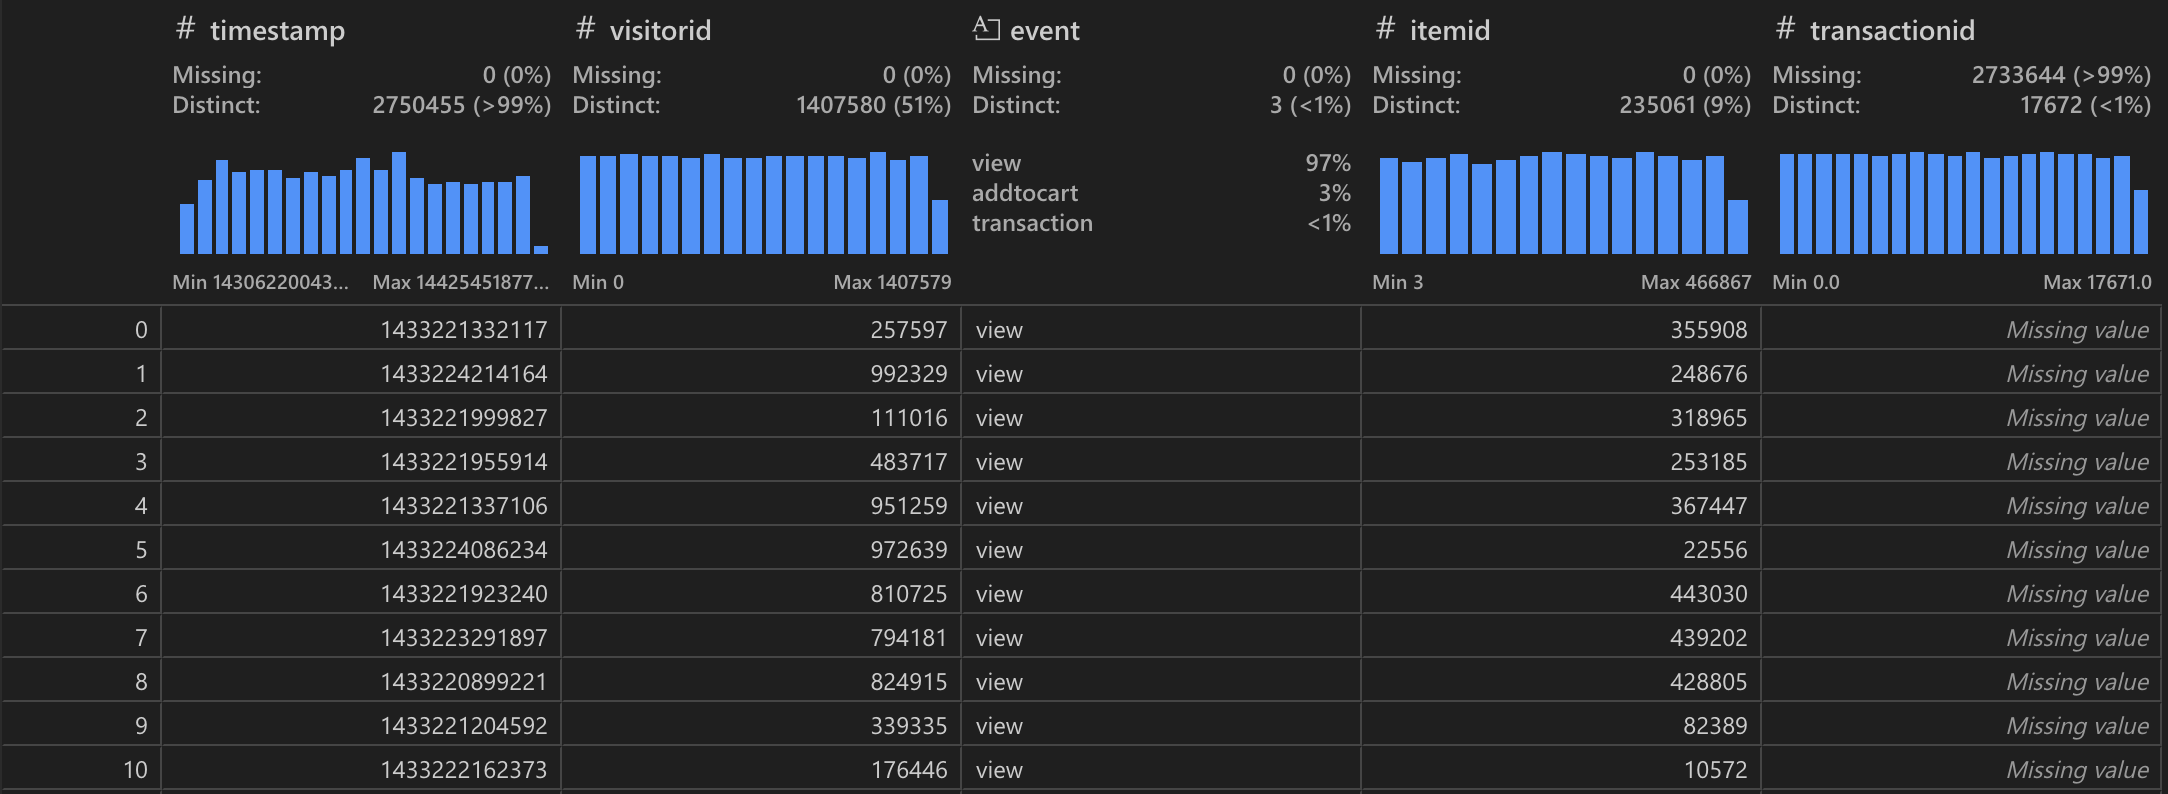

In [56]:
# Data Preprocessing

events['timestamp'] = pd.to_datetime(events['timestamp'], unit='ms')
event_map = {'view': 0, 'addtocart': 1, 'transaction': 2}
events['event'] = events['event'].map(event_map)
events['visitorid'] = events['visitorid'].astype(int)
print(events.head())

                timestamp  visitorid  event  itemid  transactionid
0 2015-06-02 05:02:12.117     257597      0  355908            NaN
1 2015-06-02 05:50:14.164     992329      0  248676            NaN
2 2015-06-02 05:13:19.827     111016      0  318965            NaN
3 2015-06-02 05:12:35.914     483717      0  253185            NaN
4 2015-06-02 05:02:17.106     951259      0  367447            NaN


In [57]:
events = events.sort_values(by=['visitorid', 'timestamp'])
print(events.head())

                      timestamp  visitorid  event  itemid  transactionid
1361687 2015-09-11 20:49:49.439          0      0  285930            NaN
1367212 2015-09-11 20:52:39.591          0      0  357564            NaN
1367342 2015-09-11 20:55:17.175          0      0   67045            NaN
830385  2015-08-13 17:46:06.444          1      0   72028            NaN
742616  2015-08-07 17:51:44.567          2      0  325215            NaN


In [58]:
# Count how many records each visitor has to make window size determination reasonable

grouped = events.groupby(['visitorid'])
visitor_counts = grouped.size().reset_index(name='event_count')
print(visitor_counts.describe())

          visitorid   event_count
count  1.407580e+06  1.407580e+06
mean   7.037895e+05  1.958042e+00
std    4.063335e+05  1.258049e+01
min    0.000000e+00  1.000000e+00
25%    3.518948e+05  1.000000e+00
50%    7.037895e+05  1.000000e+00
75%    1.055684e+06  2.000000e+00
max    1.407579e+06  7.757000e+03


In [59]:
# Filtering out off outliers (anomaly behavior: too many times of view by a person)

view_counts = events[events['event'] == 'view'].groupby(['visitorid', 'itemid']).size().reset_index(name='view_count')
excessive = view_counts[view_counts['view_count'] > 20]
events = events.merge(excessive, on=['visitorid', 'itemid'], how='left', indicator=True)
events = events[events['_merge'] == 'left_only'].drop(columns=['view_count', '_merge'])

In [60]:
session_keys = events.groupby(['visitorid', 'itemid']).size().reset_index()[['visitorid', 'itemid']].drop_duplicates()

# Split sessions into 60% train, 20% val, 20% test
train_keys, temp_keys = train_test_split(session_keys, test_size=0.4, random_state=42)
val_keys, test_keys   = train_test_split(temp_keys, test_size=0.5, random_state=42)

# Merge with raw event table
train_df = events.merge(train_keys, on=['visitorid', 'itemid'])
val_df   = events.merge(val_keys,   on=['visitorid', 'itemid'])
test_df  = events.merge(test_keys,  on=['visitorid', 'itemid'])

# Sort each group
train_df = train_df.sort_values(by=['visitorid', 'timestamp'])
val_df   = val_df.sort_values(by=['visitorid', 'timestamp'])
test_df  = test_df.sort_values(by=['visitorid', 'timestamp'])

train_df.head() # for example checking

,timestamp,visitorid,event,itemid,transactionid
0,2015-09-11 20:49:49.439,0,0,285930,NaN
1,2015-08-07 17:51:44.567,2,0,325215,NaN
2,2015-08-07 17:53:33.790,2,0,325215,NaN
3,2015-08-07 17:56:52.664,2,0,259884,NaN
4,2015-08-07 18:01:08.920,2,0,216305,NaN


In [61]:
# Feature Engineering

def generate_sequences(df, window=2):
    X, y = [], []
    skipped = 0
    grouped = df.groupby('visitorid')

    for _, group in grouped:
        events_seq = group['event'].tolist()
        if len(events_seq) < window + 1:
            skipped += 1
            continue
        for i in range(len(events_seq) - window):
            X.append(events_seq[i:i+window])
            y.append(events_seq[i+window])

    print(f"Skipped users with < {window+1} actions: {skipped}")
    return np.array(X), np.array(y)

X_train, y_train = generate_sequences(train_df, window=2)
X_val,   y_val   = generate_sequences(val_df,   window=2)
X_test,  y_test  = generate_sequences(test_df,  window=2)

Skipped users with < 3 actions: 816127
Skipped users with < 3 actions: 325261
Skipped users with < 3 actions: 325189


In [62]:
# Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(3, input_dim)  # 3 classes
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

input_dim, hidden_dim, output_dim = 16, 32, 3
model = LSTMModel(input_dim, hidden_dim, output_dim)

In [63]:
weight_sets = [
    torch.tensor([1.0, 5.0, 15.0]),
    torch.tensor([1.0, 5.0, 30.0]),
]

best_f1 = 0
best_weights = None
best_model = None

for w in weight_sets:
    print(f"\nTrying class_weights = {w.tolist()}")
    model = LSTMModel(input_dim=16, hidden_dim=32, output_dim=3)
    loss_fn = nn.CrossEntropyLoss(weight=w)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # train (simple 5-epoch)
    for epoch in range(5):
        model.train()
        Xb = torch.LongTensor(X_train)
        yb = torch.LongTensor(y_train)
        preds = model(Xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # evaluate on val
    model.eval()
    with torch.no_grad():
        val_preds = model(torch.LongTensor(X_val))
        pred_cls = val_preds.argmax(dim=1).numpy()
        f1 = f1_score(y_val, pred_cls, average='weighted')
        print(f"Val F1 Score: {f1:.4f}")
        if f1 > best_f1:
            best_f1 = f1
            best_weights = w
            best_model = model




Trying class_weights = [1.0, 5.0, 15.0]
Val F1 Score: 0.8596

Trying class_weights = [1.0, 5.0, 30.0]
Val F1 Score: 0.0068


In [64]:
from sklearn.metrics import classification_report, confusion_matrix

print("Evaluating best model on test set...")
with torch.no_grad():
    test_preds = best_model(torch.LongTensor(X_test))
    test_cls = test_preds.argmax(dim=1).numpy()
    print(classification_report(y_test, test_cls, target_names=['view', 'cart', 'purchase']))


Evaluating best model on test set...
              precision    recall  f1-score   support

        view       0.94      0.93      0.93    105725
        cart       0.00      0.00      0.00      7068
    purchase       0.28      0.76      0.40      4128

    accuracy                           0.87    116921
   macro avg       0.40      0.57      0.45    116921
weighted avg       0.86      0.87      0.86    116921



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
# Save PyTorch model
torch.save(best_model.state_dict(), "best_model.pth")

In [68]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 43.9 MB/s eta 0:00:00


In [69]:
# Dummy input (same shape as X_val samples)
example_input = torch.LongTensor(X_val[:1])

# Export to ONNX
torch.onnx.export(
    best_model,
    example_input,
    "best_model.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=12
)